In [1]:
import torch
import torch.nn.functional as F
import torchvision.transforms as T
import numpy as np
from PIL import Image
from pathlib import Path

from tqdm import tqdm
import time
import math

import torch
from transformers import AutoImageProcessor, AutoModel
from utils.img import unnormalize

from utils.visualization import plot_feats, pca

/root/workspaces/thesis_ws/.venv/jafar/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
pretrained_model_name = "facebook/dinov3-vits16-pretrain-lvd1689m"
processor = AutoImageProcessor.from_pretrained(pretrained_model_name)
model = AutoModel.from_pretrained(
    pretrained_model_name, 
    device_map="auto", 
)

Fetching 1 files: 100%|██████████| 1/1 [00:00<00:00, 6754.11it/s]

In [3]:
import rerun as rr
rr.init("dinov3", recording_id="dinov3")
# rr.connect_grpc()
Path("/root/workspaces/thesis_ws/data/rrd_logs/dinov3/").mkdir(parents=True, exist_ok=True)
rr.save("/root/workspaces/thesis_ws/data/rrd_logs/dinov3/dinov3.rrd")

In [4]:
from PIL import Image
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# Load an image
latent_w = 32
latent_h = 18
patch_size = 16
input_w = latent_w * patch_size
input_h = latent_h * patch_size

/root/workspaces/thesis_ws/src/JAFAR/utils/img.py:24: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  mean = torch.tensor(mean).view(1, 3, 1, 1).to("cuda")  # Reshape to (1, C, 1, 1) for broadcasting
/root/workspaces/thesis_ws/src/JAFAR/utils/img.py:25: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  std = torch.tensor(std).view(1, 3, 1, 1).to("cuda")  # Reshape to (1, C, 1, 1) for broadcasting


Original Image shape: (1280, 720)
Input Image shape: torch.Size([1, 3, 288, 512])
LF feats shape: torch.Size([1, 384, 18, 32])


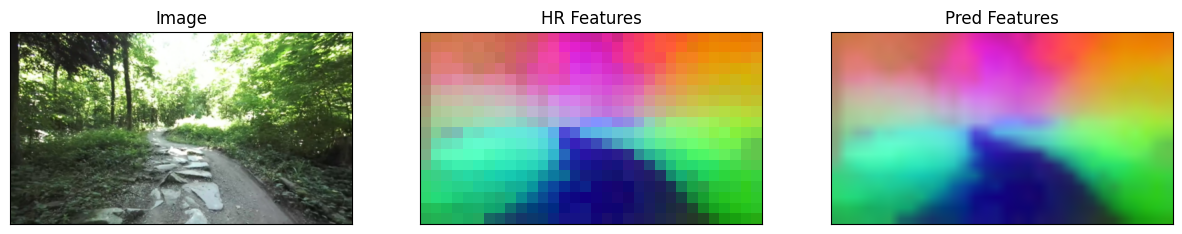

In [ ]:
image_path = "/root/repos/vlmaps/data/allmend_trail_recording_2025_12_06_full_trail_zed_sdk/images/02271.png"
image = Image.open(image_path).convert("RGB")

# Transform the image to match the input requirements of the model
mean = torch.tensor([0.485, 0.456, 0.406], device=device)
std = torch.tensor([0.229, 0.224, 0.225], device=device)
transform = T.Compose(
    [
        T.Resize((input_h, input_w)),
        T.ToTensor(),  # Convert to tensor
        T.Normalize(mean=mean, std=std),  # Normalize
    ]
)
image_batch = transform(image).unsqueeze(0).to(device)  # Add batch dimension and move to device

batch_size, input_c, input_h, input_w = image_batch.shape

with torch.inference_mode():
    outputs = model(image_batch)
    all_tokens = outputs.last_hidden_state

patch_tokens = all_tokens[:, 5:, :]

# reorder tokens into [b, c, h, w]
patch_tokens = patch_tokens.permute(0, 2, 1)
lr_feats = patch_tokens.reshape(batch_size, -1, latent_h, latent_w)

unorm_img_batch = unnormalize(image_batch, mean, std)

print("Original Image shape:", image.size)
print("Input Image shape:", unorm_img_batch.shape)
print("LF feats shape:", lr_feats.shape)

hr_feats = F.interpolate(lr_feats, size=(input_h, input_w), mode='bilinear', align_corners=False)

plot_feats(unorm_img_batch[0],lr_feats[0],hr_feats[0])

In [5]:
url = "/root/repos/vlmaps/data/allmend_trail_recording_2025_12_06_full_trail_zed_sdk/images/02271.png"

image_idxs = range(400,410,10)

for frame_idx in image_idxs:
    idx_with_zeros = f"{frame_idx:05d}"
    image_path = f"/root/repos/vlmaps/data/allmend_trail_recording_2025_12_06_full_trail_zed_sdk/images/{idx_with_zeros}.png"
    
    image = Image.open(image_path).convert("RGB")

    # Transform the image to match the input requirements of the model
    mean = torch.tensor([0.485, 0.456, 0.406], device=device)
    std = torch.tensor([0.229, 0.224, 0.225], device=device)
    transform = T.Compose(
        [
            T.Resize((input_h, input_w)),
            T.ToTensor(),  # Convert to tensor
            T.Normalize(mean=mean, std=std),  # Normalize
        ]
    )
    image_batch = transform(image).unsqueeze(0).to(device)  # Add batch dimension and move to device

    batch_size, input_c, input_h, input_w = image_batch.shape

    with torch.inference_mode():
        outputs = model(image_batch)
        all_tokens = outputs.last_hidden_state

    patch_tokens = all_tokens[:, 5:, :]

    # reorder tokens into [b, c, h, w]
    patch_tokens = patch_tokens.permute(0, 2, 1)
    lr_feats = patch_tokens.reshape(batch_size, -1, latent_h, latent_w)

    unorm_img_batch = unnormalize(image_batch, mean, std)

    hr_feats = F.interpolate(lr_feats, size=(input_h, input_w), mode='bilinear', align_corners=False)

    # PCA on LR and HR in a shared 3D space → RGB maps
    reduced, _ = pca([lr_feats, hr_feats], dim=3, use_torch_pca=True)
    lr_pca = reduced[0][0].permute(1, 2, 0)   # (H_lr, W_lr, 3)
    hr_pca = reduced[1][0].permute(1, 2, 0)   # (H, W, 3)

    rr.set_time(timeline="frame", sequence=frame_idx)
    rr.log("img/img", rr.Image(unorm_img_batch[0].permute(1,2,0)))
    rr.log(f"img/pca_dinov3", rr.Image(lr_pca))
    rr.log(f"img/pca_dinov3_bilinear", rr.Image(hr_pca))

    print("Input Image shape:", unorm_img_batch.shape)
    # print("LF feats shape:", lr_feats.shape)
    print("HR feats shape:", hr_feats.shape)

/root/workspaces/thesis_ws/src/JAFAR/utils/img.py:24: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  mean = torch.tensor(mean).view(1, 3, 1, 1).to("cuda")  # Reshape to (1, C, 1, 1) for broadcasting
/root/workspaces/thesis_ws/src/JAFAR/utils/img.py:25: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  std = torch.tensor(std).view(1, 3, 1, 1).to("cuda")  # Reshape to (1, C, 1, 1) for broadcasting


Input Image shape: torch.Size([1, 3, 288, 512])
HR feats shape: torch.Size([1, 384, 288, 512])
